In [11]:
import gymnasium as gym
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap, BoundaryNorm
from numpy.f2py.rules import options
from numpy.ma.core import argmax

from src.agent import QLearningAgent
from src.env import DiceBlackJack


In [2]:
import logging

logging.basicConfig(level=logging.WARNING, filemode="w",
                    filename="training.log", format="[%(levelname)s] %(message)s")
logging.logProcesses = False

In [3]:
learning_rate = 0.10
n_episodes = 100_000
epsilon_decay = lambda x: max(1 - np.sqrt(1.5 * x), 0)

env = DiceBlackJack()
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = QLearningAgent(env=env, learning_rate=learning_rate,
                       discount_factor=0.95, seed=0x42)

In [4]:
training_error = agent.train(n_episodes, epsilon_decay)

Training: 100%|██████████| 100000/100000 [00:16<00:00, 6233.56it/s]


In [5]:
def moving_average(input: np.ndarray, n: int = 500, mode="valid") -> np.ndarray:
    """Get the moving average."""
    output = np.convolve(np.array(input).flatten(), np.ones(n), mode=mode) / n
    steps = np.arange(output.size) + n // 2
    return steps, output


def cumulative(input: np.ndarray) -> np.ndarray:
    """Get the cumulative value."""
    input = np.array(input).flatten()
    temp = 0
    for i in range(input.size):
        temp += input[i]
        input[i] = temp
    steps = np.arange(input.size)
    return steps, input

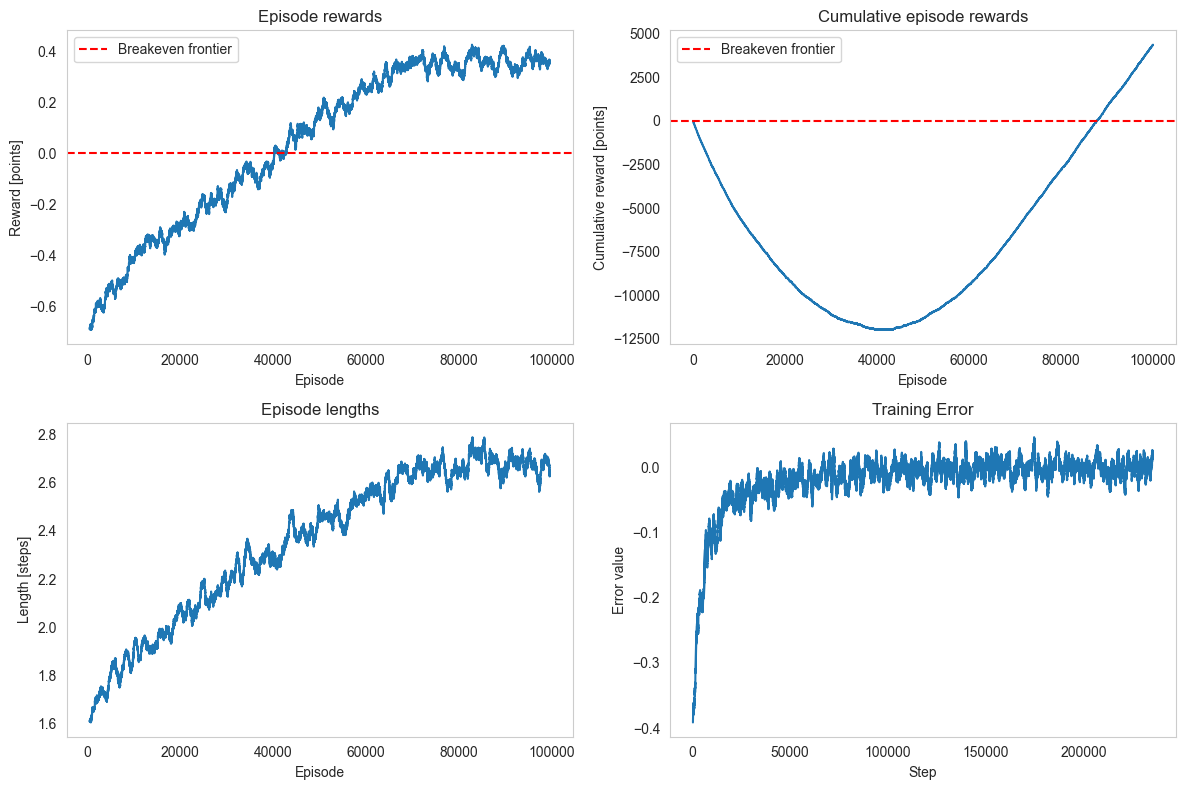

In [6]:
rolling_length = 1000
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
axs = axs.flatten()
axs[0].set_title("Episode rewards")
axs[0].grid()
axs[0].plot(*moving_average(env.return_queue, rolling_length))
axs[0].axhline(0, color="red", linestyle="--", label="Breakeven frontier")
axs[0].legend()
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward [points]")

axs[1].set_title("Cumulative episode rewards")
axs[1].grid()
axs[1].plot(*cumulative(env.return_queue))
axs[1].axhline(0, color="red", linestyle="--", label="Breakeven frontier")
axs[1].legend()
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumulative reward [points]")

axs[2].set_title("Episode lengths")
axs[2].grid()
axs[2].plot(*moving_average(env.length_queue, rolling_length))
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Length [steps]")

axs[3].set_title("Training Error")
axs[3].grid()
axs[3].plot(*moving_average(training_error, rolling_length))
axs[3].set_xlabel("Step")
axs[3].set_ylabel("Error value")

plt.tight_layout()
plt.show()

In [7]:
q_table = agent.get_q_table()
values = np.stack([v for _, v in sorted(zip(q_table.keys(), q_table.values()))])
values[values == 0] = np.nan
values = values[~np.isnan(values).all(axis=1)]

In [8]:
lst = list(sorted(q_table.keys()))
tables_data = {}

actions_and_dice_scores = []
for i in lst:
    if not (q_table[i] == [0, 0, 0, 0, 0, 0]).all():
        if i[0] not in tables_data:
            tables_data[i[0]] = []
        tables_data[i[0]].append((i[1], i[2], np.argmax(q_table[i]).item()))

In [9]:
def plot_tables_heatmaps_18(tables_dict, action_info):
    """
    Builds heatmaps based on the dictionary tables_data, where:
      - Key: 'previous score' (a total of 18 keys),
      - Value: a list of tuples (d1, d2, action),
        where d1, d2 ∈ {1..6} and action ∈ {0..5}.
    
    For each key, it draws a separate 6×6 matrix, where:
      - The Y-axis (rows) represents d1 from 1 to 6,
      - The X-axis (columns) represents d2 from 1 to 6,
      - The cell color indicates the 'action code'.
    """
    
    keys = sorted(tables_dict.keys())
    n_keys = len(keys)

    n_rows, n_cols = 3, 6
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12))

    cmap = ListedColormap(['gray'] + [action_info[i][1] for i in range(6)])
    norm = BoundaryNorm(np.arange(-1.5, 6.5, 1), cmap.N)

    for ax, key in zip(axes.flat, keys):
        grid = -np.ones((6, 6), dtype=int)
        annot = np.full((6, 6), '', dtype=object)

        for (d1, d2, action_idx) in tables_dict[key]:
            grid[d1 - 1, d2 - 1] = action_idx
            annot[d1 - 1, d2 - 1] = action_info[action_idx][0]
            ax.text(d2 - 0.5, d1 - 0.5, action_info[action_idx][0],
                            ha='center', va='center', color='black', fontsize=11)
            
        sns.heatmap(
            grid, 
            fmt='', 
            cmap=cmap, 
            norm=norm, 
            cbar=False,
            xticklabels=np.arange(1, 7),
            yticklabels=np.arange(1, 7),
            ax=ax
        )
                    
        ax.set_title(f"Prev. Score = {key}", fontsize=14)
        ax.set_xlabel("Second die")
        ax.set_ylabel("First die")
        ax.invert_yaxis()
        
    for i in range(n_keys, n_rows*n_cols):
        axes.flat[i].set_visible(False)

    plt.tight_layout()
    plt.show()

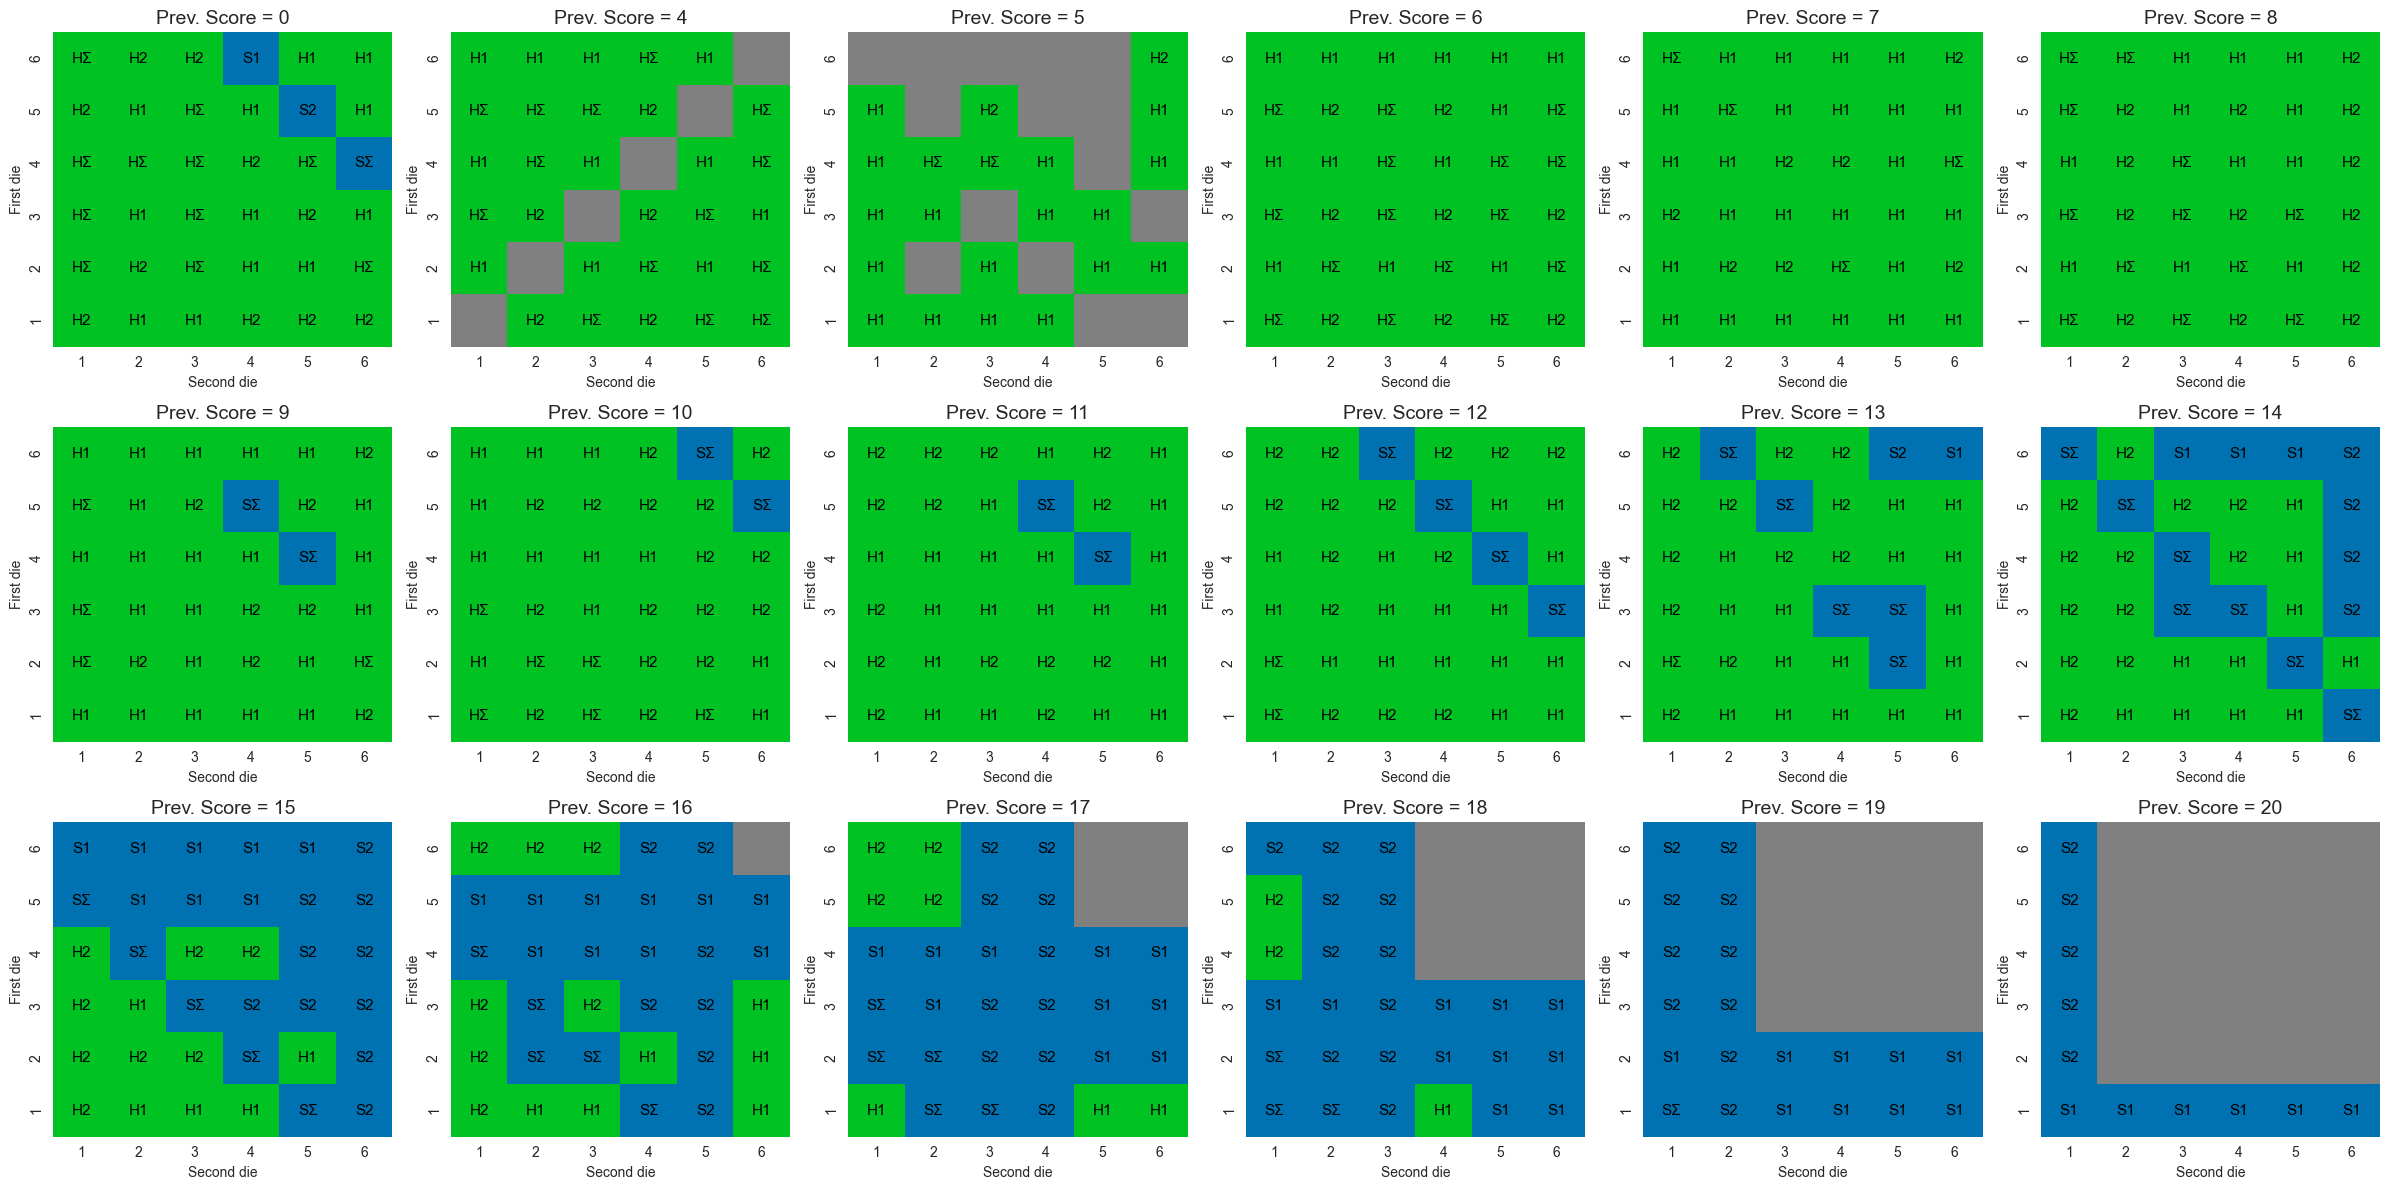

In [13]:
if __name__ == "__main__":
    example_tables_data = tables_data
    action_info = {
        0: ('H1', '#00C222'),
        1: ('H2', '#00C222'),
        2: ('HΣ', '#00C222'),
        3: ('S1', '#0072B2'),
        4: ('S2', '#0072B2'),
        5: ('SΣ', '#0072B2'),
    }

    plot_tables_heatmaps_18(example_tables_data, action_info)